In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
annotations_path = []
for dirname, _, filenames in os.walk('/kaggle/input/face-mask-detection/annotations'):
    for filename in filenames:
        annotations_path.append(os.path.join(dirname, filename))
images_path = []
for dirname, _, filenames in os.walk('/kaggle/input/face-mask-detection/images'):
    for filename in filenames:
        images_path.append(os.path.join(dirname, filename))
        
annotations_path.sort()
images_path.sort()

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
#Létrehozunk egy map-et, melyben minden képhez fog tartozni egy "BoundingBox" tömb
import xml.etree.ElementTree as et

class BoundingBox :
    def __init__(self, xmin, ymin, xmax, ymax, label):
        self.xmin = xmin
        self.xmax = xmax
        self.ymin = ymin
        self.ymax = ymax
        self.label = label
        
class ImageSize:
     def __init__(self, x, y):
        self.x = x
        self.y = y

image_boxes_assoc = {}
image_size_assoc = {}

for annotation_path in annotations_path:
    with open(annotation_path) as annotation:
        xml = et.parse(annotation)
        root = xml.getroot()
        img = root[1].text
        image_size_assoc[img] = ImageSize(root[2][0].text,root[2][1].text )
        
        bounding_boxes = []
        for i in range(4,len(root)):
            if((int(root[i][5][2].text)-int(root[i][5][0].text))>10 and (int(root[i][5][3].text)-int(root[i][5][1].text))>10):
                bounding_boxes.append(BoundingBox(root[i][5][0].text,
                                        root[i][5][1].text, root[i][5][2].text, root[i][5][3].text,root[i][0].text))
        #for i in bounding_boxes:
        #    print(img, i.xmin, " ", i.ymin, " ", i.xmax, " ", i.ymax, " ", i.label )
        image_boxes_assoc[img] = bounding_boxes

In [3]:
#Létrehozzuk a dobozokat

import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from tensorflow.python.keras.preprocessing.image import img_to_array
import random as random

images = []
labels = []

image_size = 150

for img_path in images_path:
    img_name = img_path.split('images/')[1]
    img = cv2.imread(img_path)
    cv2.resize(img, (int(image_size_assoc[img_name].x),
                     int(image_size_assoc[img_name].y)))
    
    for box in image_boxes_assoc[img_name]:
        if box.label== 'with_mask':
            #if(random.random()<0.75):
            #    continue
            labels.append(0)
        elif box.label=='without_mask':
            labels.append(1)
        else:
            labels.append(2)
        face = img[int(box.ymin) : int(box.ymax), int(box.xmin) : int(box.xmax)]
        face = cv2.resize(face, (image_size, image_size))
        face = img_to_array(face)
        images.append(face)
        
a = np.array(labels)
unique, counts = np.unique(a, return_counts=True)
dict(zip(unique, counts))

{0: 2794, 1: 570, 2: 115}

In [4]:
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import preprocess_input

train_label_Ids_keras = np_utils.to_categorical(labels, num_classes=3)
x_train, x_test, y_train, y_test = train_test_split(
    images, train_label_Ids_keras, test_size = 0.1, shuffle=True)

train_original_size = len(x_train)
for i in range(train_original_size):
    if y_train[i][1]==1:
        for j in range(5):
            x_train.append(x_train[i])
            without_mask_label =  np.array([[0, 1, 0]])
            y_train = np.concatenate((y_train, without_mask_label))
    elif y_train[i][2]==1:
        for j in range(20):
            x_train.append(x_train[i])
            incorrect_mask_label =  np.array([[0, 0, 1]])
            y_train = np.concatenate((y_train, incorrect_mask_label))
        

x_train = np.array(x_train)
x_test = np.array(x_test)

a = np.array(y_train)
unique, counts = np.unique(a, return_counts=True)
dict(zip(unique, counts))

BATCH_SIZE = 32

train_gen = ImageDataGenerator(
        zoom_range=0.2,
        rotation_range=15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        preprocessing_function=preprocess_input)

train_generator = train_gen.flow(
    np.array(x_train),
    y_train,
    batch_size = BATCH_SIZE,
    shuffle = True
)
test_gen = ImageDataGenerator( 
     preprocessing_function=preprocess_input)

test_generator = test_gen.flow(
    np.array(x_test),
    y_test,
    batch_size = BATCH_SIZE,
    shuffle = False)


x_train = preprocess_input(x_train)

x_test = preprocess_input(x_test)

In [5]:
from keras.layers import Input, Flatten, Dense, Dropout
from keras.models import Model, Sequential
from keras.applications.resnet import ResNet50

set_trainable = False

model = Sequential()
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(image_size,image_size,3))
for layer in base_model.layers[:-12]:
    layer.trainable=False
    
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))

model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 5, 5, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               13107456  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 771       
Total params: 36,695,939
Trainable params: 17,573,891
Non-trainable params: 19,122,048
_________________________________________________________________


In [6]:
from keras.optimizers import Adam
adam = Adam(lr=1e-5)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=adam)


#history = model.fit(x_train, y_train,
#                    batch_size=BATCH_SIZE,
#                    epochs=10,
#                    validation_data = (x_test, y_test))

history = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=10,
        validation_data=test_generator) 

print('\nhistory dict:', history.history)

Epoch 1/10
245/245 [==============================] - 48s 195ms/step - loss: 0.7396 - accuracy: 0.7406 - val_loss: 0.2235 - val_accuracy: 0.9138
Epoch 2/10
245/245 [==============================] - 47s 192ms/step - loss: 0.3070 - accuracy: 0.8848 - val_loss: 0.1583 - val_accuracy: 0.9253
Epoch 3/10
245/245 [==============================] - 47s 193ms/step - loss: 0.1975 - accuracy: 0.9288 - val_loss: 0.1550 - val_accuracy: 0.9282
Epoch 4/10
245/245 [==============================] - 45s 185ms/step - loss: 0.1599 - accuracy: 0.9397 - val_loss: 0.1116 - val_accuracy: 0.9425
Epoch 5/10
245/245 [==============================] - 45s 183ms/step - loss: 0.1220 - accuracy: 0.9589 - val_loss: 0.1001 - val_accuracy: 0.9483
Epoch 6/10
245/245 [==============================] - 44s 179ms/step - loss: 0.0980 - accuracy: 0.9674 - val_loss: 0.1011 - val_accuracy: 0.9569
Epoch 7/10
245/245 [==============================] - 44s 180ms/step - loss: 0.0741 - accuracy: 0.9744 - val_loss: 0.0997 - val_ac

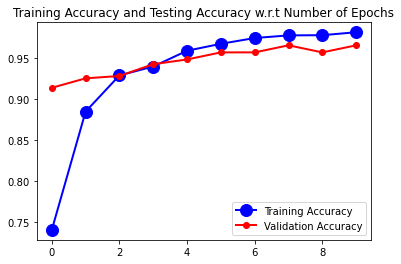

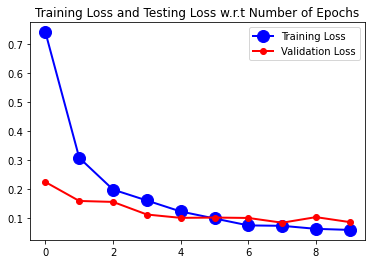

In [7]:
import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
No_Of_Epochs = range(10)

plt.plot(No_Of_Epochs, train_acc, marker = 'o', color = 'blue', markersize = 12, 
                 linewidth = 2, label = 'Training Accuracy')
plt.plot(No_Of_Epochs, val_acc, marker = '.', color = 'red', markersize = 12, 
                 linewidth = 2, label = 'Validation Accuracy')

plt.title('Training Accuracy and Testing Accuracy w.r.t Number of Epochs')

plt.legend()

plt.figure()

plt.plot(No_Of_Epochs, train_loss, marker = 'o', color = 'blue', markersize = 12, 
                 linewidth = 2, label = 'Training Loss')
plt.plot(No_Of_Epochs, val_loss, marker = '.', color = 'red', markersize = 12, 
                 linewidth = 2, label = 'Validation Loss')

plt.title('Training Loss and Testing Loss w.r.t Number of Epochs')

plt.legend()

plt.show()

In [8]:
from sklearn.metrics import classification_report

Y_test = np.argmax(y_test, axis=1) # Convert one-hot to index
y_pred = model.predict_classes(x_test)
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       284
           1       0.90      0.96      0.93        54
           2       0.64      0.70      0.67        10

    accuracy                           0.97       348
   macro avg       0.84      0.88      0.86       348
weighted avg       0.97      0.97      0.97       348



In [9]:
from keras.models import model_from_json

#serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


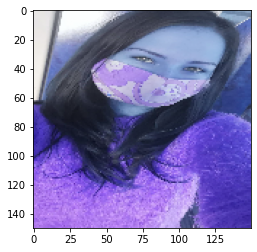

With Mask
98.98257851600647 %


In [19]:
import matplotlib.image as mpimg

#data_dir = '../input/face-mask-detection/images/'
data_dir = '../input/tomika/'
for dirs in os.walk(data_dir) :
    for files in dirs:
        for img in files:
            if 'Robi.PNG' in img:
                image_path = os.path.join(data_dir,img)
                image = cv2.imread(image_path)
                image = cv2.resize(image, (150, 150))
                img = image / 255.0
                plt.figure()
                imgplot = plt.imshow(img)
                plt.show()  
                image = np.expand_dims(image, axis = 0)
                image = preprocess_input(image)
                switcher = {
                    0 : "With Mask",
                    1 : "Without Mask",
                    2 : "Mask Weared Incorrectly"
                }
                print(switcher[np.argmax(model.predict(image))])
                print(np.max(model.predict(image))*100 , '%')